# **BioPred Phase 1 Feature Engineering**

In this portion of the project, we will look to:

1. Take our notebook from our EDA phase and edit it, creating new features using the power of RDKit.

2. Encode our canonical_smiles feature using Morgan Fingerprints so they are able to be read as numerical, and so we can then use them in our models.

3. Take our categorical features and encode them separately, using One-Hot or similar so they are represented appropriately in the dataframe.

#### First as we have done in other notebooks let's import our libraries and read in our current eda_df file, saving it to another variable so we can work on it without deviating from the original data file still in progress.

In [16]:
# List libraries needed for this notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, GraphDescriptors, rdFingerprintGenerator
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Establish file path to read in eda_df for usage here.
file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/eda_1_phase_1.parquet"
fe_df = pd.read_parquet(file_path)

print(fe_df.shape)
fe_df.head()

(343659, 13)


,canonical_smiles,full_mwt,alogp,psa,hba_lipinski,hbd_lipinski,aromatic_rings,heavy_atoms,rtb,molecular_species,min_standard_value,activity_count,tid
0,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,317.18,4.50,26.30,2,0,2,19,1,NEUTRAL,4.615121,1.098612,11934
1,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,364.18,4.54,26.30,2,0,2,19,1,NEUTRAL,3.433987,0.693147,11934
2,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,262.31,3.78,26.30,2,0,2,20,1,NEUTRAL,4.564348,0.693147,11934
3,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,433.51,2.68,93.81,8,2,3,32,5,NEUTRAL,0.412110,0.693147,104304
4,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,435.53,1.80,110.88,9,2,3,29,5,NEUTRAL,3.551914,0.693147,104304


#### So we will now look to expand our features using RDKit.  It comes with some built-in features we can use with our canonical_smiles data to enhance our dataset, providing new looks into our data.  We will then go back to our EDA ntbk with this and examine how this effects our data and our target. 

#### A lot of the features we already have in our current dataframe were provided by RDKit originally, so it is a matter of obtaining ones to be complementary to our goals.  Let's take a look at some of the features that can be added:

**Molecular Complexity (BertzCT, BalabanJ)**:
Complexity often correlates with unique molecular interactions.

**Shape Descriptors (FractionCSP3, Kappa Indices)**:
Shape and symmetry are linked to drug-likeness.

**Surface Area (LabuteASA)**:
Surface area impacts molecular accessbility to biological targets.

**HallKierAlpha**:
Measures molecular branching, often correlating with structural diversity and bioactivity.

**PEOE_VSA**:
Key for understanding electrostatic interactions.

**Kappa1, Kappa2, Kappa3**:
Quantify molecular shape and symmetry.

**ChiX indices (Chi0, Chi1)**:
Molecular connectivity indices for structural diversity.


#### Ok now let's write the function that uses our canonical_smiles feature and calculates the new features that we want to use from the RDKit library.

In [3]:
def rdkit_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {}
    return {
        # Features for Structural Complexity
        "bertz_ct" : GraphDescriptors.BertzCT(mol),
        "hallkier_alpha" : Descriptors.HallKierAlpha(mol),
        "balaban_j" : Descriptors.BalabanJ(mol),
        
        # Features for Shape
        "fraction_csp3" : Descriptors.FractionCSP3(mol),
        
        # Features for Surface Area
        "labute_asa" : Descriptors.LabuteASA(mol),
        "peoe_vsa1" : Descriptors.PEOE_VSA1(mol),
        "peoe_vsa2" : Descriptors.PEOE_VSA2(mol),
        
        # Features for Connectivity and Topology
        "kappa1" : Descriptors.Kappa1(mol),
        "kappa2" : Descriptors.Kappa2(mol),
        "kappa3" : Descriptors.Kappa3(mol),
        "chi0" : Descriptors.Chi0(mol),
        "chi1" : Descriptors.Chi1(mol)
    }

# Now apply to our dataset.
fe_df['rdkit_feats'] = fe_df['canonical_smiles'].apply(rdkit_features)
rdkit_feats_df = pd.DataFrame(fe_df['rdkit_feats'].tolist())
fe_df = pd.concat([fe_df, rdkit_feats_df], axis = 1)
fe_df.drop(columns = ['rdkit_feats'], inplace = True)

fe_df.head()

,canonical_smiles,full_mwt,alogp,psa,hba_lipinski,hbd_lipinski,aromatic_rings,heavy_atoms,rtb,molecular_species,...,balaban_j,fraction_csp3,labute_asa,peoe_vsa1,peoe_vsa2,kappa1,kappa2,kappa3,chi0,chi1
0,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,317.18,4.50,26.30,2,0,2,19,1,NEUTRAL,...,2.032678,0.187500,119.749901,4.736863,4.794537,12.425157,5.174545,2.302843,13.242276,9.292025
1,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,364.18,4.54,26.30,2,0,2,19,1,NEUTRAL,...,2.032678,0.187500,125.144192,4.736863,4.794537,12.662582,5.327835,2.388698,13.242276,9.292025
2,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,262.31,3.78,26.30,2,0,2,20,1,NEUTRAL,...,1.988982,0.166667,117.611463,4.736863,4.794537,12.501099,5.223444,2.188684,13.949383,9.792025
3,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,433.51,2.68,93.81,8,2,3,32,5,NEUTRAL,...,1.273158,0.375000,186.495387,25.007213,4.794537,20.358115,8.180995,3.656405,22.241912,15.584050
4,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,435.53,1.80,110.88,9,2,3,29,5,NEUTRAL,...,1.582585,0.333333,172.281067,20.107303,0.000000,19.676288,7.653369,3.561938,20.595647,13.934220


#### Great now before we analyze our new data and format it let's encode our SMILES strings into Morgan fingerprints.  For reference, this converts the canonical_smiles strings into machine-readable (read numerical) format for modeling.

In [4]:
# function to encode the morgan fingerprints, return empty array for invalid smiles data.

# Initialize the Morgan Generator
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius = 2, fpSize = 2048) # for radius and bit size

def encode_smiles_to_prints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [0] * morgan_gen.fpSize # Here is where we return an empty array for the invalid smiles.
    return list(morgan_gen.GetFingerprint(mol)) # Convert to a list to be able to store easier

# Similar process now for how we just did for the feature creation.
fe_df['morgan_fingerprints'] = fe_df['canonical_smiles'].apply(encode_smiles_to_prints)

fe_df.head()

,canonical_smiles,full_mwt,alogp,psa,hba_lipinski,hbd_lipinski,aromatic_rings,heavy_atoms,rtb,molecular_species,...,fraction_csp3,labute_asa,peoe_vsa1,peoe_vsa2,kappa1,kappa2,kappa3,chi0,chi1,morgan_fingerprints
0,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,317.18,4.50,26.30,2,0,2,19,1,NEUTRAL,...,0.187500,119.749901,4.736863,4.794537,12.425157,5.174545,2.302843,13.242276,9.292025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,364.18,4.54,26.30,2,0,2,19,1,NEUTRAL,...,0.187500,125.144192,4.736863,4.794537,12.662582,5.327835,2.388698,13.242276,9.292025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,262.31,3.78,26.30,2,0,2,20,1,NEUTRAL,...,0.166667,117.611463,4.736863,4.794537,12.501099,5.223444,2.188684,13.949383,9.792025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,433.51,2.68,93.81,8,2,3,32,5,NEUTRAL,...,0.375000,186.495387,25.007213,4.794537,20.358115,8.180995,3.656405,22.241912,15.584050,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,435.53,1.80,110.88,9,2,3,29,5,NEUTRAL,...,0.333333,172.281067,20.107303,0.000000,19.676288,7.653369,3.561938,20.595647,13.934220,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


#### Now a quick step we will do is make all of our new fingerprints into NumPy arrays.  This helps us utilize them in PCA (if needed) and our modeling.

In [5]:
# Convert the morgan_fingerprints column to a NumPy array
fingerprint_array = np.array(fe_df["morgan_fingerprints"].tolist())

# Check for all-zero fingerprints row-wise
num_zero_fingerprints = np.sum(np.all(fingerprint_array == 0, axis=1))

print(f"Number of rows with all-zero fingerprints: {num_zero_fingerprints}")


Number of rows with all-zero fingerprints: 0


In [11]:
# quick check for missing values
print(fe_df["morgan_fingerprints"].isnull().sum())
print(fe_df["morgan_fingerprints"].apply(type).value_counts())


0
morgan_fingerprints
<class 'list'>    343659
Name: count, dtype: int64


#### At this point we will save our progress and create a new parquet file that we will call back in our EDA notebook, to continue our analysis.  

In [6]:
file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/feat_eng_1_phase_1.parquet"
fe_df.to_parquet(file_path, index = False)
print("Feature engineering phase 1 data saved as Parquet in df_files in Data folder.")

Feature engineering phase 1 data saved as Parquet in df_files in Data folder.


#### We just finished preprocessing in the phase_1_eda ntbk with feature generation and filtering, adding some new features that correlate well with our target through looking at the mean.  Let's read in the current iteration of that df now.

In [7]:
file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/eda_2_phase_1.parquet"
feat_fil_df = pd.read_parquet(file_path)

feat_fil_df.head()

,canonical_smiles,full_mwt,alogp,psa,hba_lipinski,hbd_lipinski,aromatic_rings,heavy_atoms,rtb,min_standard_value,...,bertz_ct_target_mean,tid_target_mean,psa_target_mean,full_mwt_target_mean,labute_asa_target_mean,chi0_target_mean,hallkier_alpha_target_mean,kappa1_target_mean,chi1_target_mean,peoe_vsa1_target_mean
0,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,317.18,4.50,26.30,2,0,2,19,1,4.62,...,3.68,3.32,3.32,4.62,2.55,3.32,2.95,3.52,3.06,3.02
1,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,364.18,4.54,26.30,2,0,2,19,1,3.43,...,3.68,3.32,3.32,4.34,3.06,3.32,3.18,3.36,3.06,3.02
2,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,262.31,3.78,26.30,2,0,2,20,1,4.56,...,4.56,3.32,3.32,3.19,2.76,3.29,3.13,3.01,3.38,3.02
3,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,433.51,2.68,93.81,8,2,3,32,5,0.41,...,3.37,3.34,2.54,3.00,2.61,2.85,2.90,2.66,2.93,2.89
4,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,435.53,1.80,110.88,9,2,3,29,5,3.55,...,1.74,3.34,2.65,3.23,2.79,3.07,3.08,3.05,3.01,2.82


#### We will now look into feature filtering, looking into methods such as RFECV (Recursive Feature Elimination with Cross Validation), VIF (Variance Inflation Factor) and MI Scores (Mutual Information, which is a great complement to VIF as it shows which features predict on the target as a percent).  By starting with 37 features and scoping down, we will be able to use a focused set of features that through this filtering method we can see will help us before we go into our modeling stage so that it increases our metric output even further.

#### First we will start with the RFECV method, and as a note of clarification we are performing Cross-Validation with our RFE method as usually you specify how many features you want to retain through the process of feature elimination.  By including Cross-Validation into the RFE filtering method it does it FOR you, as well as providing a score just like if you were to use cross-validation on a model.  Let's take a look to see how this works.

Optimal number of features: 29
Selected features: ['alogp', 'hba_lipinski', 'aromatic_rings', 'heavy_atoms', 'rtb', 'hallkier_alpha', 'balaban_j', 'fraction_csp3', 'labute_asa', 'peoe_vsa1', 'peoe_vsa2', 'kappa1', 'kappa2', 'kappa3', 'chi0', 'chi1', 'species_BASE', 'species_NEUTRAL', 'species_ZWITTERION', 'bertz_ct_target_mean', 'tid_target_mean', 'psa_target_mean', 'full_mwt_target_mean', 'labute_asa_target_mean', 'chi0_target_mean', 'hallkier_alpha_target_mean', 'kappa1_target_mean', 'chi1_target_mean', 'peoe_vsa1_target_mean']


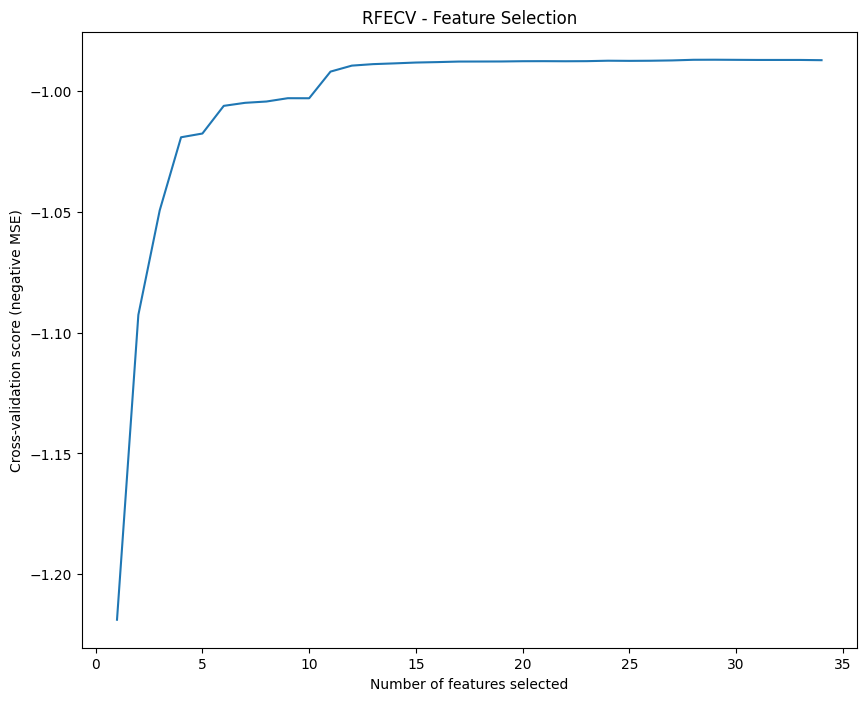

In [19]:
# Set up our X,y for target variables from our current dataframe
X = feat_fil_df.drop(columns = ['min_standard_value', 'canonical_smiles', 'morgan_fingerprints']) # Drop everything but our target
y = feat_fil_df['min_standard_value']

# Define and set up a base model to use RFECV
model_lr = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rfecv_lr = RFECV(estimator=model_lr, step = 1, scoring = 'neg_mean_squared_error')

# Fit the RFECV
rfecv_lr.fit(X,y)

# Extract the features
selected_features_lr = X.columns[rfecv_lr.support_]
print(f"Optimal number of features: {rfecv_lr.n_features_}")
print(f"Selected features: {list(selected_features_lr)}")

# Plot RFECV results
plt.figure(figsize = (10,8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (negative MSE)")
plt.title("RFECV - Feature Selection")
plt.plot(range(1, len(rfecv_lr.cv_results_['mean_test_score']) + 1), rfecv_lr.cv_results_['mean_test_score'])
plt.show()

In [29]:
# Define the VIF function
def compute_vif(df, threshold = 15):
    """
    Here we will just compute the VIF for the features that are the output from our RFECV method.
    Our args is simply the input df, and the return is the df with VIF values for each remaining feature.
    * Note to set threshold higher than base 10 to see what features are leftover, then play it down until
    acceptable range of features are left over at threshold level of 10 or less."""
    
    df = df.copy()
    high_vif_features = []
    
    while True:
        vif_data = pd.DataFrame()
        vif_data['Feature'] = df.columns
        vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
        # Identify features above the threshold
        high_vif = vif_data[vif_data['VIF'] > threshold]
        
        if high_vif.empty:
            break
    
        # Remove the feature(s) with highest VIF according to the threshold
        remove_feat = high_vif.sort_values(by = 'VIF', ascending = False).iloc[0]['Feature']
        high_vif_features.append(remove_feat)
        df.drop(columns = [remove_feat], inplace = True)
        
        print(f"Removing {remove_feat} (VIF: {high_vif.sort_values(by='VIF', ascending=False).iloc[0]['VIF']:.2f})")
    
    return vif_data.sort_values(by = 'VIF', ascending = False), df.columns.tolist()

# Format data for the vif call
vif_features_df = feat_fil_df[selected_features_lr].copy()

# Set the threshold manually to customize and change it, as we will need to for multiple runs.
vif_threshold = 30

# Call and sort the results
vif_results, vif_filtered_features = compute_vif(vif_features_df, threshold = vif_threshold)

# Print results
print("\nVIF Results:")
print(vif_results)
print(f"\nFeatures remaining after filtering (VIF <= {vif_threshold}): {vif_filtered_features}")

Removing chi1 (VIF: 11422.47)
Removing chi0 (VIF: 4503.93)
Removing labute_asa (VIF: 2831.89)
Removing heavy_atoms (VIF: 795.59)
Removing kappa2 (VIF: 390.04)
Removing chi1_target_mean (VIF: 317.62)
Removing kappa1_target_mean (VIF: 236.97)
Removing kappa1 (VIF: 169.03)
Removing peoe_vsa1_target_mean (VIF: 163.02)
Removing hallkier_alpha_target_mean (VIF: 130.09)
Removing chi0_target_mean (VIF: 103.00)
Removing hallkier_alpha (VIF: 53.15)
Removing labute_asa_target_mean (VIF: 51.94)
Removing psa_target_mean (VIF: 36.40)
Removing hba_lipinski (VIF: 35.36)
Removing full_mwt_target_mean (VIF: 33.22)

VIF Results:
                 Feature        VIF
7                 kappa3  27.317634
12       tid_target_mean  22.887713
2                    rtb  16.815746
1         aromatic_rings  14.441229
0                  alogp  12.832095
11  bertz_ct_target_mean  12.513021
3              balaban_j  10.837356
9        species_NEUTRAL   7.461980
4          fraction_csp3   7.443013
5              peoe_vs

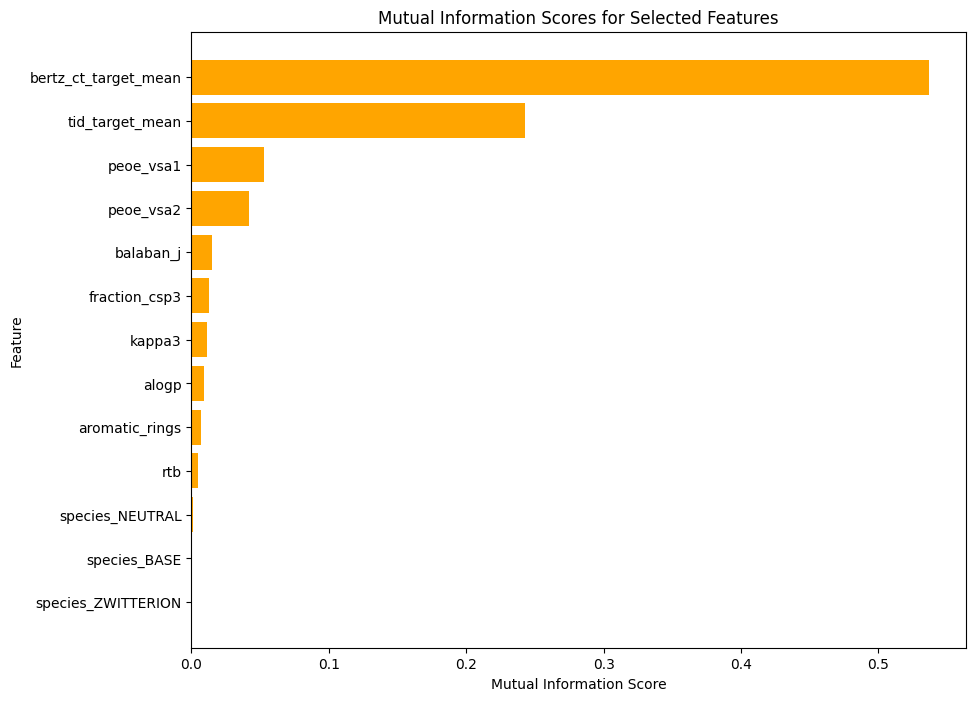

In [30]:
# Run the MI Scores, starting with defining X and y again using our filtered list of features from our VIF list.
X_mi = feat_fil_df[['aromatic_rings', 'bertz_ct_target_mean', 'balaban_j', 'rtb', 'alogp', 'species_NEUTRAL', 'peoe_vsa1',
                    'fraction_csp3', 'peoe_vsa2', 'species_BASE', 'species_ZWITTERION', 'tid_target_mean', 'kappa3']]
y_mi = feat_fil_df['min_standard_value']

# Compute the MI scores
mi_scores = mutual_info_regression(X_mi, y_mi, discrete_features='auto')

# Convert to a dataframe
mi_results = pd.DataFrame({'Feature': X_mi.columns, 'MI Score': mi_scores})
mi_results = mi_results.sort_values(by = 'MI Score', ascending = False)

# Plot the MI Scores
plt.figure(figsize = (10,8))
plt.barh(mi_results['Feature'], mi_results['MI Score'], color = 'orange')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Mutual Information Scores for Selected Features')
plt.gca().invert_yaxis() # Shows highest score at the top
plt.show()